In [1]:
!pip install ydata-synthetic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Fou

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import timedelta

from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
from ydata_synthetic.synthesizers.timeseries.timegan.model import TimeGAN

In [3]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive

In [5]:
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

In [6]:
def make_traindata_timegan(input_dir_list):
  train = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train = pd.concat([train, train_df])
  train['obs_time'] = pd.to_datetime(train['obs_time'])
  train['datetime'] = train['obs_time'] + train['DAT'].apply(lambda x: timedelta(days=x))

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  train.loc[train['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train.loc[train['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # column 삭제
  col_names = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  train = train[['datetime'] + col_names]

  return train

In [7]:
input_dir_list = sorted(glob('/content/dataset/train_input/CASE_20.csv'))
train_df = make_traindata_timegan(input_dir_list)

<ipython-input-6-76c108936ded>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['obs_time'] = pd.to_datetime(train['obs_time'])


In [8]:
train_df = train_df.drop(columns='datetime')
train_data = real_data_loading(train_df.values, seq_len=24)
print(len(train_data), train_data[0].shape)

648 (24, 4)


In [9]:
synthesizer_timegan = TimeGAN.load('/mydrive/model_param/CASE_20/timegan/synthesizer_env.pkl')

In [11]:
synthetic_data = synthesizer_timegan.sample(len(train_data))
print(len(synthetic_data), synthetic_data[0].shape)

648 (24, 4)


### Descriptive statistics: real vs synth

In [17]:
real_arr = np.array(train_data)
real_arr = real_arr.reshape(-1, real_arr.shape[-1])
real_df = pd.DataFrame(real_arr, columns=['temp', 'humidity', 'ec', 'co2'])

synth_df = pd.DataFrame()
for i in range(synthetic_data[0].shape[1]):
  synth_df = pd.concat([synth_df, synthetic_data[i]], axis=0).reset_index(drop=True)
synth_df.columns = ['temp', 'humidity', 'ec', 'co2']

print(real_df.describe())
print('')
print(synth_df.describe())

               temp      humidity            ec           co2
count  15552.000000  15552.000000  15552.000000  15552.000000
mean       0.466843      0.755749      0.830694      0.238696
std        0.247043      0.211892      0.295893      0.126683
min        0.000000      0.000000      0.000000      0.000000
25%        0.228962      0.605984      0.916254      0.187970
50%        0.571847      0.843612      0.942565      0.242113
75%        0.649253      0.927855      0.977049      0.306857
max        1.000000      1.000000      1.000000      1.000000

            temp   humidity         ec        co2
count  96.000000  96.000000  96.000000  96.000000
mean    0.428420   0.616045   0.807929   0.266215
std     0.258203   0.225961   0.282042   0.089994
min     0.050558   0.256773   0.012925   0.022792
25%     0.172450   0.423823   0.863960   0.209678
50%     0.466001   0.568704   0.939592   0.263840
75%     0.673465   0.830851   0.956976   0.334688
max     0.932062   0.986540   0.982163   

### Compare sample plot: real vs synth

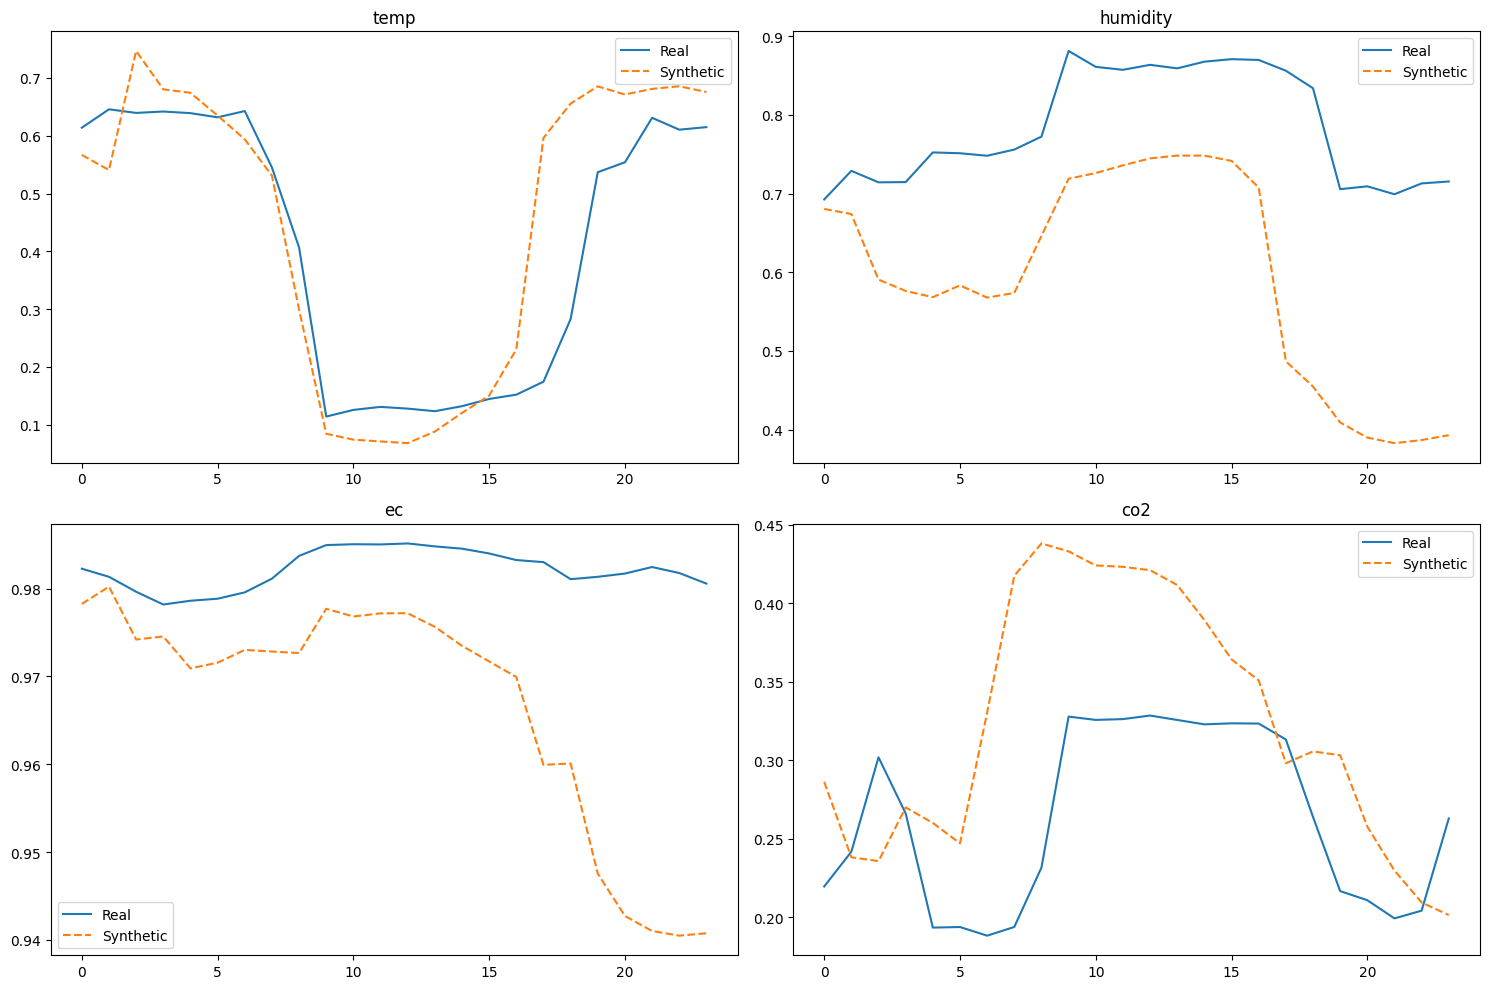

In [19]:
#Reshaping the data
cols = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
titles = ['temp', 'humidity', 'ec', 'co2']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(train_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': train_data[obs][:, j],
                   'Synthetic': synthetic_data[obs].iloc[:, j]})
    df.plot(ax=axes[j],
            title = titles[j],
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

### Box plot: real vs synth

In [20]:
def boxplot(real_df, synth_df, col):
  fig, ax = plt.subplots()
  ax.boxplot([real_df[col], synth_df[col]])
  plt.title('real vs synth')
  plt.xticks([1,2], [f'real_{col}', f'synth_{col}'])
  plt.show()

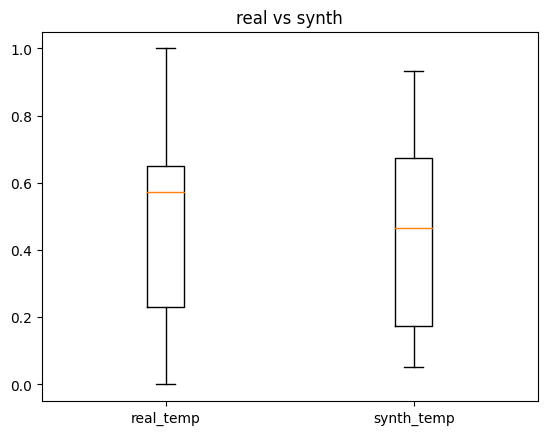

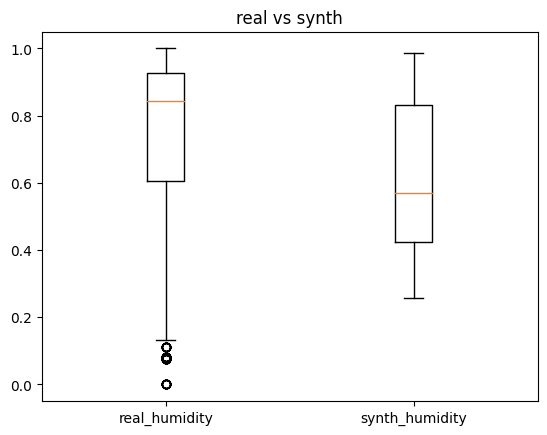

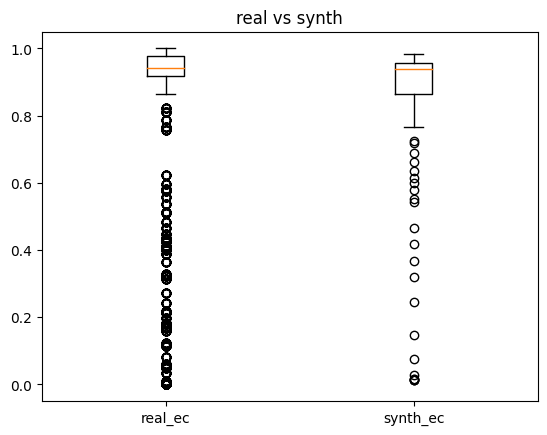

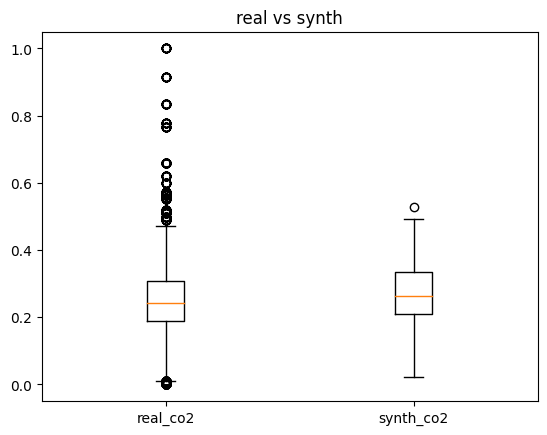

In [22]:
boxplot(real_df, synth_df, 'temp')
boxplot(real_df, synth_df, 'humidity')
boxplot(real_df, synth_df, 'ec')
boxplot(real_df, synth_df, 'co2')

### PCA & TSNE

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seq_len = 24
sample_size = 250
idx = np.random.permutation(len(train_data))[:sample_size]

real_sample = np.asarray(train_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

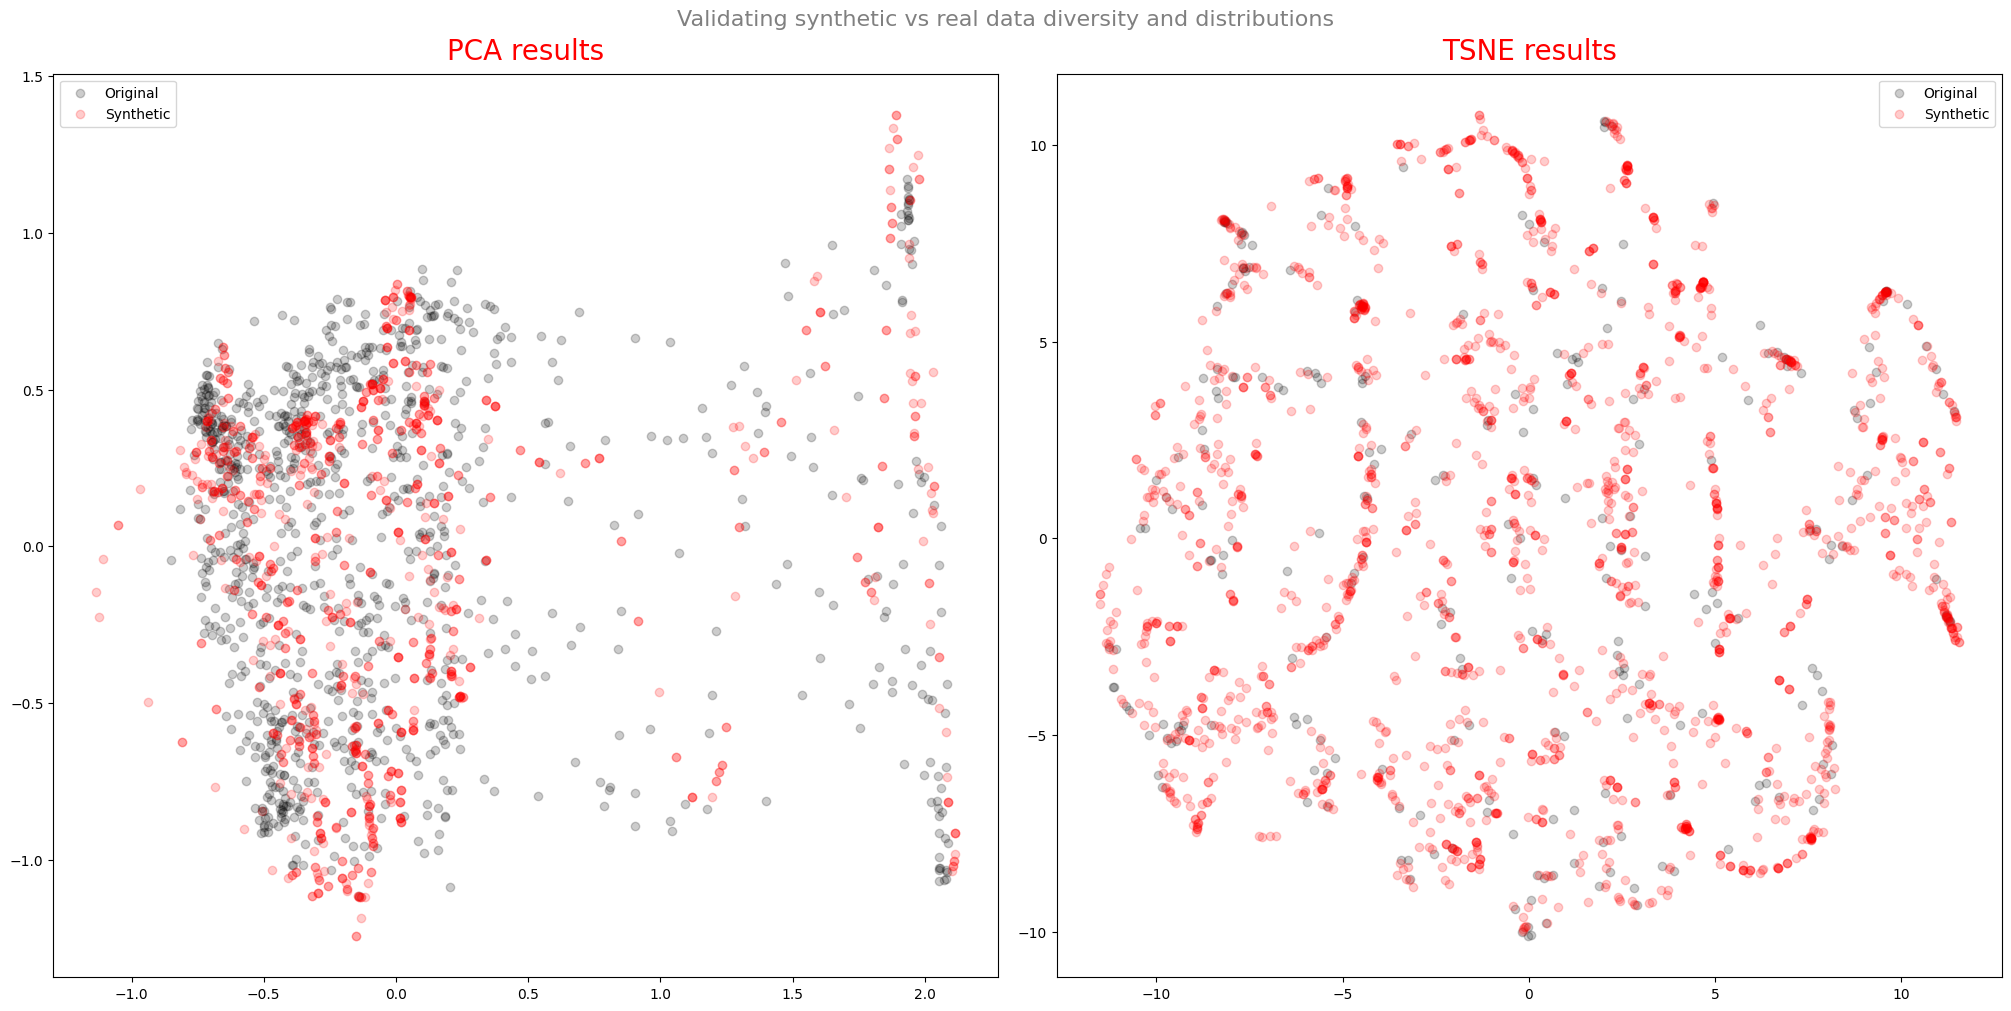

In [24]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')